# Clustering and Viz Experimentation

This notebook is used to visualize the distributions and spectral signatures of the data. It does not change the data but just inspects it.

In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [92]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
#2010 tiles
# tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
# tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
# tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 500
max_count_per_class = 200

checking general values for pixels

In [72]:
tile_list = ['028011']
px = rnn_pixels.make_pixels(1, tile_list)

In [102]:
n = 200000
random_px_subset = random.sample(px, n)
random_px_subset

[((3073, 3887), '028011'),
 ((1108, 4866), '028011'),
 ((2811, 1584), '028011'),
 ((292, 4811), '028011'),
 ((1031, 488), '028011'),
 ((3535, 4315), '028011'),
 ((2492, 2495), '028011'),
 ((1367, 2289), '028011'),
 ((4125, 2426), '028011'),
 ((211, 838), '028011'),
 ((1573, 1244), '028011'),
 ((1083, 662), '028011'),
 ((388, 1544), '028011'),
 ((355, 3747), '028011'),
 ((143, 1955), '028011'),
 ((771, 1326), '028011'),
 ((1967, 166), '028011'),
 ((3917, 2100), '028011'),
 ((379, 2809), '028011'),
 ((924, 4824), '028011'),
 ((3638, 4151), '028011'),
 ((2190, 4260), '028011'),
 ((4909, 4507), '028011'),
 ((3989, 1331), '028011'),
 ((3659, 644), '028011'),
 ((890, 491), '028011'),
 ((799, 4152), '028011'),
 ((2856, 2431), '028011'),
 ((1947, 3336), '028011'),
 ((1364, 3737), '028011'),
 ((3469, 3760), '028011'),
 ((3491, 4820), '028011'),
 ((2366, 1884), '028011'),
 ((2641, 2142), '028011'),
 ((1927, 665), '028011'),
 ((1198, 4432), '028011'),
 ((4478, 546), '028011'),
 ((4106, 79), '0280

In [117]:
len(train_px)

720

In [126]:
train_px

[((4899.0, 3005.0), '028011', 1),
 ((3855.0, 1779.0), '029011', 0),
 ((2969.0, 2002.0), '028011', 2),
 ((1508.0, 3761.0), '028012', 4),
 ((3053.0, 870.0), '029011', 0),
 ((1512.0, 511.0), '029011', 0),
 ((2707.0, 1560.0), '029011', 4),
 ((2020.0, 1898.0), '028012', 4),
 ((4343.0, 2260.0), '028011', 3),
 ((1024.0, 2516.0), '028011', 3),
 ((678.0, 4044.0), '028011', 3),
 ((2785.0, 3291.0), '028011', 2),
 ((3896.0, 3023.0), '028011', 0),
 ((1458.0, 2177.0), '028011', 3),
 ((4488.0, 4558.0), '028011', 0),
 ((1954.0, 4685.0), '028011', 0),
 ((274.0, 4160.0), '028012', 5),
 ((4853.0, 158.0), '029011', 4),
 ((4502.0, 3196.0), '028011', 2),
 ((3534.0, 967.0), '028011', 1),
 ((4584.0, 1817.0), '028011', 3),
 ((4738.0, 2480.0), '028011', 2),
 ((3817.0, 1610.0), '029011', 4),
 ((4169.0, 1000.0), '028011', 3),
 ((3186.0, 1637.0), '028011', 2),
 ((1476.0, 3189.0), '028012', 0),
 ((4240.0, 3643.0), '028011', 5),
 ((969.0, 2118.0), '028011', 3),
 ((2174.0, 1005.0), '028011', 3),
 ((4056.0, 3497.0), '

In [123]:
tile_size = 9
#px_to_use = random_px_subset
clean_pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, np.array(train_px)[:,:2], tile_size, buffer_pix=1)
print(len(clean_pixels))

665


In [161]:
pix_array = []
for pix in np.array(clean_pixels)[:,0]:
    pix_array.append([pix[0], pix[1]])
pix_array = np.array(pix_array)

In [4]:
train_gdf = gpd.read_file('shapefiles/train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name'], row['label']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((2655, 1551), '029011', 4))

In [198]:
#val_gdf = gpd.read_file('shapefiles/test_buffered_points140520_val.shp')
val_gdf = gpd.read_file('shapefiles/test1999_buffered_points140520_val_subset.shp')
train_px = []


per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 100:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            train_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(train_px)

len(train_px), train_px[0]

(600, ((15.0, 4033.0), '028012', 5))

In [191]:
tf_series = val_gdf.row.isin(pix_array[:,0]) & val_gdf.col.isin(pix_array[:,1])
val_gdf_subset = val_gdf[tf_series]
val_gdf_subset.to_file('shapefiles/test1999_buffered_points140520_val_subset.shp')

In [199]:
tile_size=1
batch_size=1
class_count = 6
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, normalize=False)

In [200]:
all_imgs = []
lc_lab = []
count = 0
while count < len(train_px):
    image_b, label_b = next(w_generator)
    label_b = np.argmax(label_b)#['landcover'])
    for i in range(0,5):
        #print(image_b.shape)
        all_imgs.append(image_b[0,i,0,0,:])
    lc_lab.append(label_b)
    count +=1

In [201]:
lc_lab = np.array(lc_lab)
lc_lab.shape

(600,)

In [202]:
random_data = np.array(all_imgs)
random_data.shape

(3000, 7)

array([0.07488907, 0.09927103, 0.10203543, 0.2042752 , 0.19177433,
       0.13437327, 0.28114573])

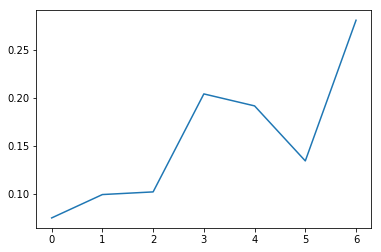

In [203]:
fig, ax = plt.subplots()
ax.plot(np.mean(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.mean(random_data,axis=0)

array([0.07488907, 0.09927103, 0.10203543, 0.2042752 , 0.19177433,
       0.13437327, 0.28114573])

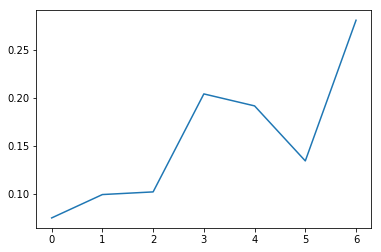

In [204]:
fig, ax = plt.subplots()
ax.plot(np.mean(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.mean(random_data,axis=0)

array([0.0575 , 0.0751 , 0.0711 , 0.21295, 0.1819 , 0.10085, 0.289  ])

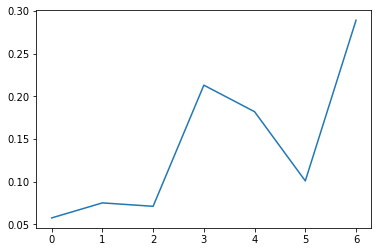

In [205]:
fig, ax = plt.subplots()
ax.plot(np.median(random_data,axis=0))
np.median(random_data,axis=0)

array([0.0575 , 0.0751 , 0.0711 , 0.21295, 0.1819 , 0.10085, 0.289  ])

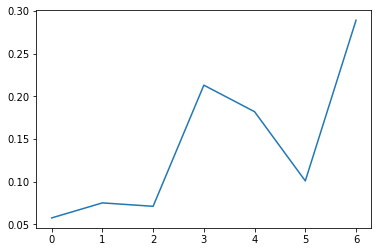

In [206]:
fig, ax = plt.subplots()
ax.plot(np.median(random_data,axis=0))
np.median(random_data,axis=0)

array([0.0498605 , 0.06524123, 0.07706638, 0.11706336, 0.12746167,
       0.11426028, 0.31424359])

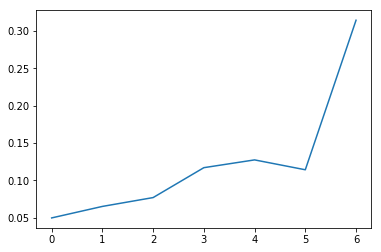

In [207]:
fig,ax = plt.subplots()
ax.plot(np.std(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.std(random_data,axis=0)

array([0.0498605 , 0.06524123, 0.07706638, 0.11706336, 0.12746167,
       0.11426028, 0.31424359])

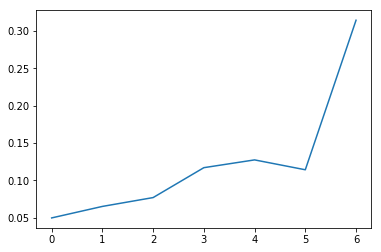

In [208]:
fig,ax = plt.subplots()
ax.plot(np.std(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.std(random_data,axis=0)

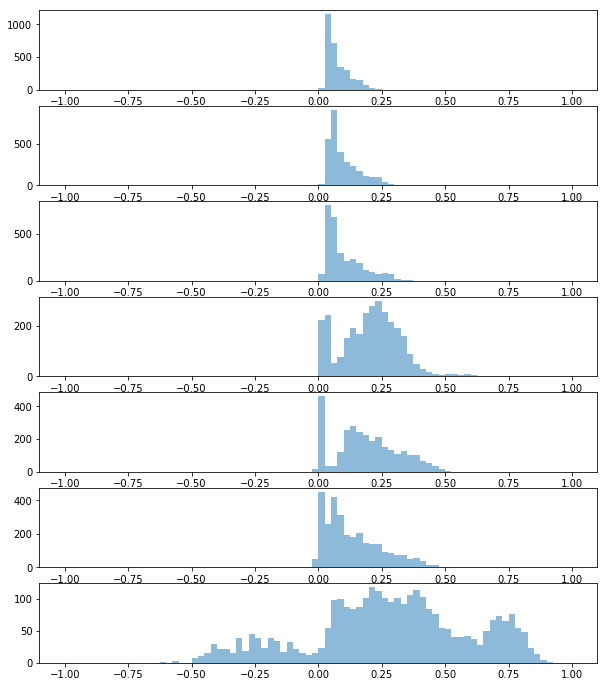

In [209]:
fig,ax = plt.subplots(7,1, figsize=(10,12))
for i in range(0,7):
    ax[i].hist(random_data[:,i].flatten(), range=(-1,1), bins=80, alpha=0.5)
plt.show()

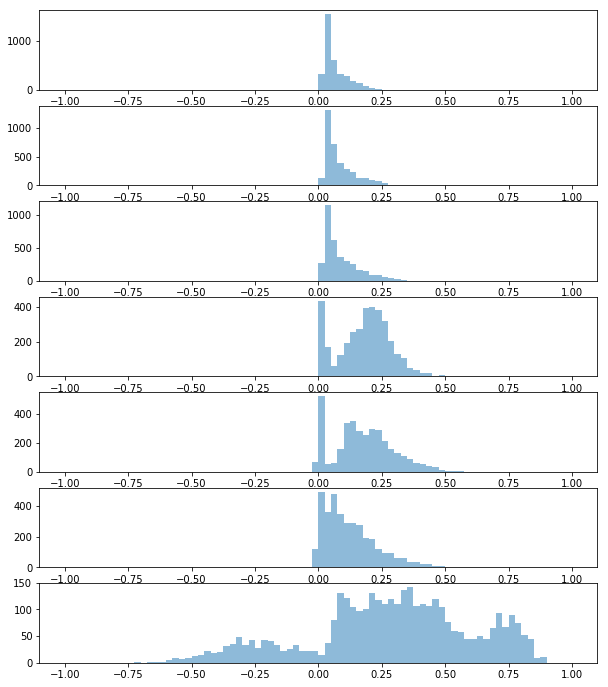

In [81]:
fig,ax = plt.subplots(7,1, figsize=(10,12))
for i in range(0,7):
    ax[i].hist(random_data[:,i].flatten(), range=(-1,1), bins=80, alpha=0.5)
plt.show()

## Spectral Signatures

Landsat 5 specs from USGS https://www.usgs.gov/land-resources/nli/landsat/landsat-5

In [210]:
all_imgs = random_data.reshape(-1,5,7)

In [211]:
np.mean(all_imgs[lc_lab==0, :,:], axis=0).shape

(5, 7)

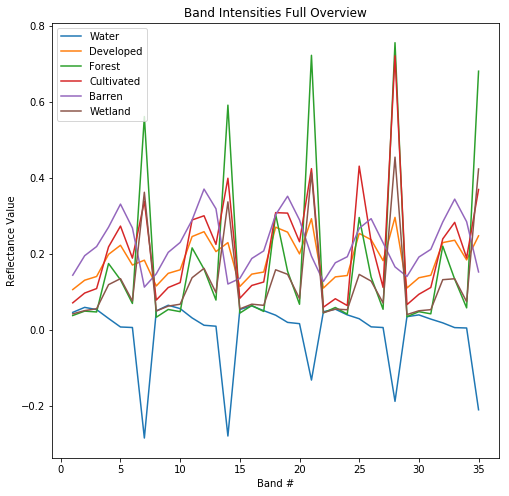

In [217]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,36)

for class_index in class_dict:
    band_intensity = np.mean(all_imgs[lc_lab==class_index, :,:], axis=0).flatten()
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


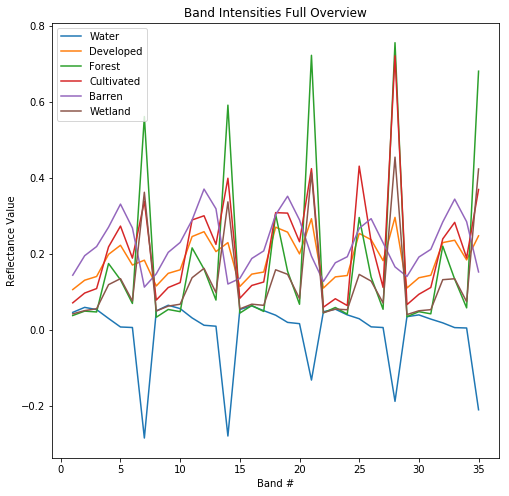

In [212]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,36)

for class_index in class_dict:
    band_intensity = np.mean(all_imgs[lc_lab==class_index, :,:], axis=0).flatten()
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


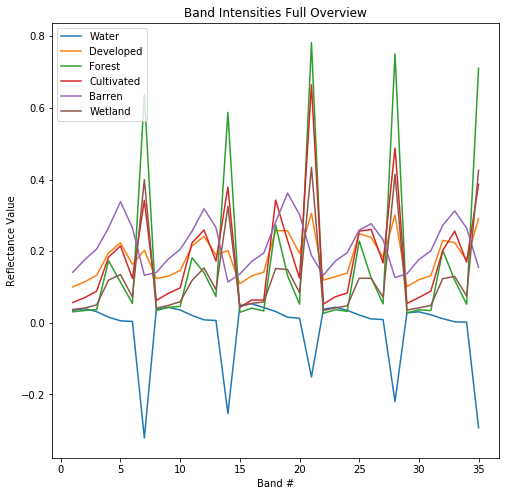

In [85]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,36)

for class_index in class_dict:
    band_intensity = np.mean(all_imgs[lc_lab==class_index, :,:], axis=0).flatten()
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


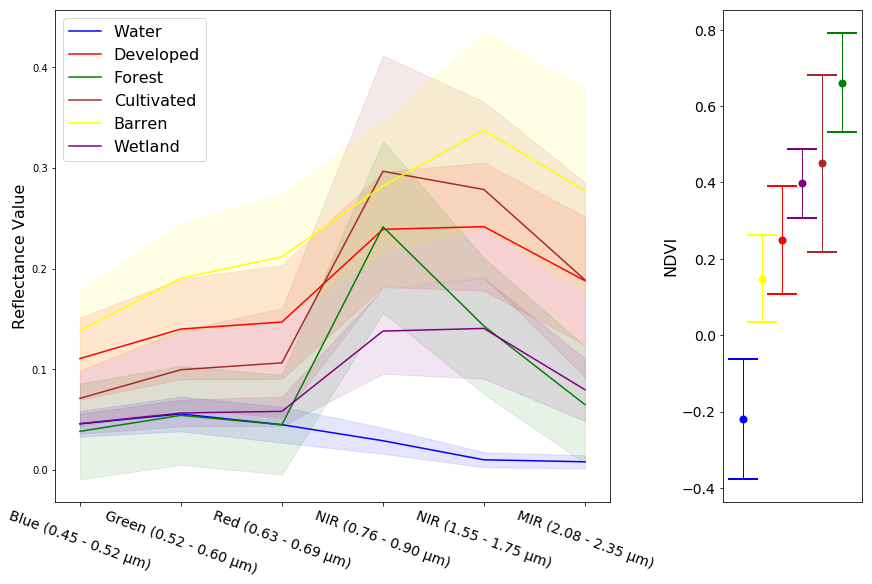

In [319]:
fig = plt.figure(constrained_layout=True, figsize=[12,8])

gs = fig.add_gridspec(1,10)
ax = fig.add_subplot(gs[:, :-2])
ax2 = fig.add_subplot(gs[:,-2:])

# numbers 1-8
band_count = np.arange(1,7)
band_num = 6

colors = ['blue', 'red', 'green', 'brown', 'yellow', 'purple']

for class_index in class_dict:
    # reshape into 5 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(all_imgs[lc_lab==class_index,:,:band_num].reshape(-1,time_steps,band_num), axis=(0,1))
    band_std = np.std(all_imgs[lc_lab==class_index,:,:band_num].reshape(-1,time_steps,band_num), axis=(0,1))
    ax.plot(band_count, band_intensity, label=class_dict[class_index], color=colors[class_index])
    #ax.errorbar(band_count, band_intensity, band_std, fmt='o', color=colors[class_index])
    ax.fill_between(band_count, band_intensity-band_std, band_intensity+band_std, color=colors[class_index], alpha=0.1)
# plot them as lines

# Add some axis labels
ax.set_xticks(np.arange(1, 7, step=1))


ax.set_xticklabels(['Blue (0.45 - 0.52 µm)',
'Green (0.52 - 0.60 µm)',
'Red (0.63 - 0.69 µm)',
'NIR (0.76 - 0.90 µm)',
'NIR (1.55 - 1.75 µm)',
'MIR (2.08 - 2.35 µm)'], rotation=-20, fontsize=14)



for idx, class_index in enumerate([0,4,1,5,3,2]):
    # reshape into 5 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(all_imgs[lc_lab==class_index,:,band_num:].reshape(-1,time_steps,1), axis=(0,1))
    band_std = np.std(all_imgs[lc_lab==class_index,:,band_num:].reshape(-1,time_steps,1), axis=(0,1))
    #ax.plot(1, band_intensity, label=class_dict[class_index], color=colors[class_index])
    ax2.errorbar(idx, band_intensity, yerr=band_std, fmt='o', color=colors[class_index], capsize=15, elinewidth=1, markeredgewidth=2, alpha=1)
    #ax.errorbar(band_count, band_intensity, band_std, fmt='o', color=colors[class_index])
    #ax2.fill_between(1, band_intensity-band_std, band_intensity+band_std, color=colors[class_index], alpha=0.1)
# plot them as lines

ax2.set_xticks([])
ax2.set_xlim(-1,6)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylabel('Reflectance Value', fontsize=16)
ax2.set_ylabel('NDVI', fontsize=16)
# Add a title
#ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left', fontsize=16)
fig.savefig('spectral_sigs.png', bbox_inches='tight', dpi=600)

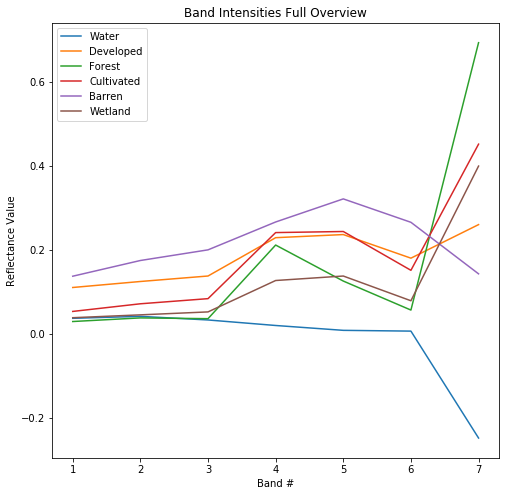

In [86]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,8)

for class_index in class_dict:
    # reshape into 5 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(all_imgs[lc_lab==class_index,:,:].reshape(-1,time_steps,7), axis=(0,1))
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [219]:
all_imgs.shape

(600, 5, 7)

In [224]:
range(time_steps)

range(0, 5)

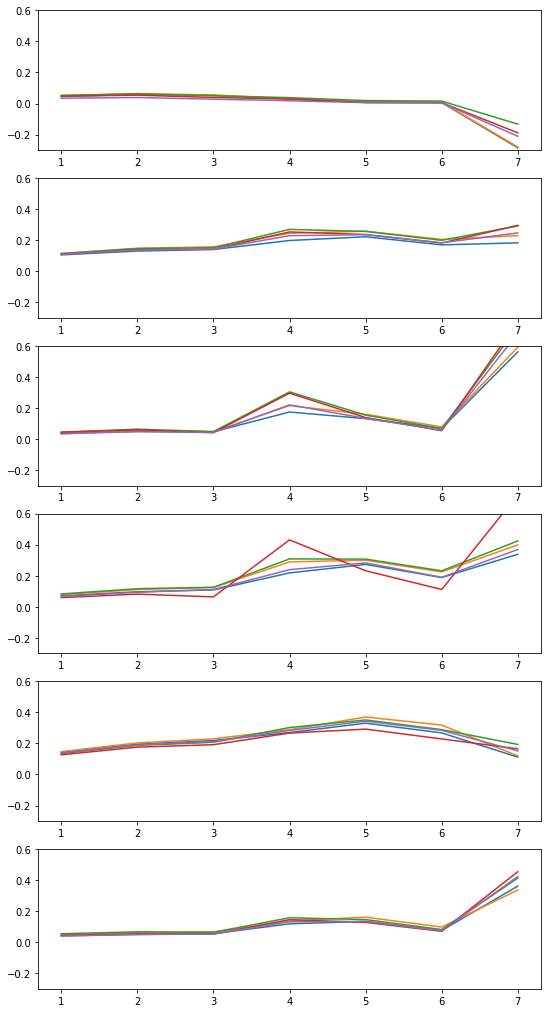

In [230]:
fig, ax = plt.subplots(6,1, figsize=[9,18])

# numbers 1-8
band_count = np.arange(1,8)

for class_index in class_dict:
    # reshape into 5 time steps of 
    time_steps = len(tiles['028012'])
    for step in range(time_steps):
        band_intensity = np.mean(all_imgs[lc_lab==class_index,step,:],axis=(0))
        #print(band_count, band_intensity)
        ax[class_index].plot(band_count, band_intensity, label=class_dict[class_index])
        ax[class_index].set_ylim(-0.3, 0.6)
# plot them as lines

# Add some axis labels
#ax.set_xlabel('Band #')
#ax.set_ylabel('Reflectance Value')
# Add a title
#ax.set_title('Band Intensities Full Overview')
#ax.legend(loc='upper left')


### Dendrogram

In [107]:
np.mean(all_imgs,axis=1).shape

(720, 7)

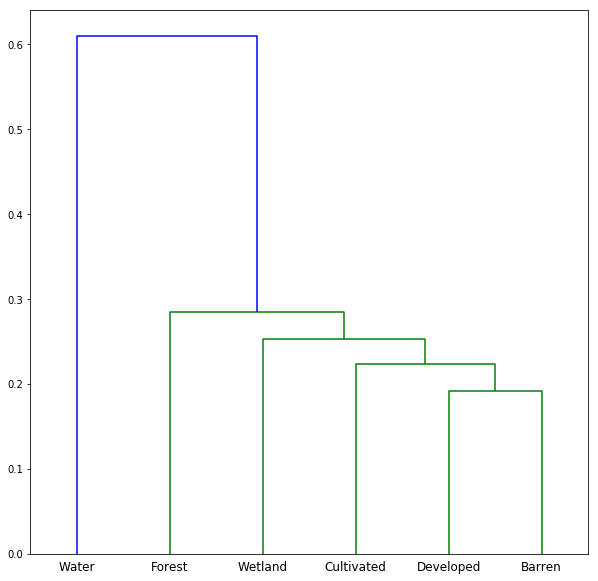

In [214]:
from scipy.cluster import hierarchy

image_avgs = []    
all_imgs_yearly_mean = np.mean(all_imgs,axis=1)
for class_index in class_dict:
    image_avgs.append(np.mean(all_imgs_yearly_mean[lc_lab==class_index, :], axis=0))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

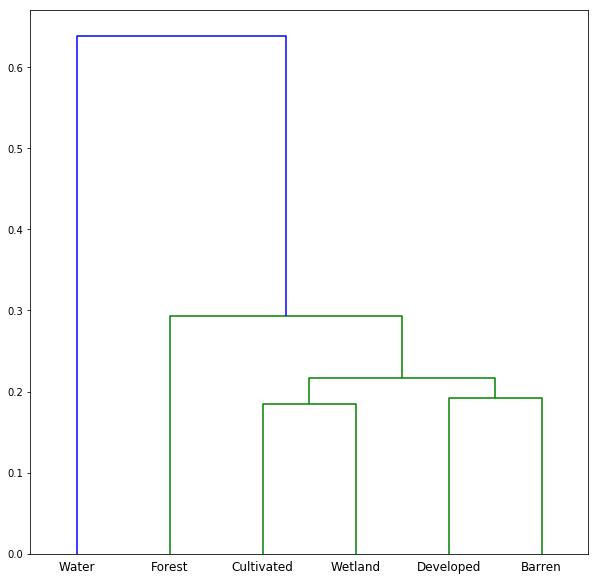

In [88]:
from scipy.cluster import hierarchy

image_avgs = []    
all_imgs_yearly_mean = np.mean(all_imgs,axis=1)
for class_index in class_dict:
    image_avgs.append(np.mean(all_imgs_yearly_mean[lc_lab==class_index, :], axis=0))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

### PCA and Clustering

In [215]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_imgs_yearly_mean)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : lc_lab})

Explained variation per principal component: [0.69323337 0.28886343 0.0107953 ]


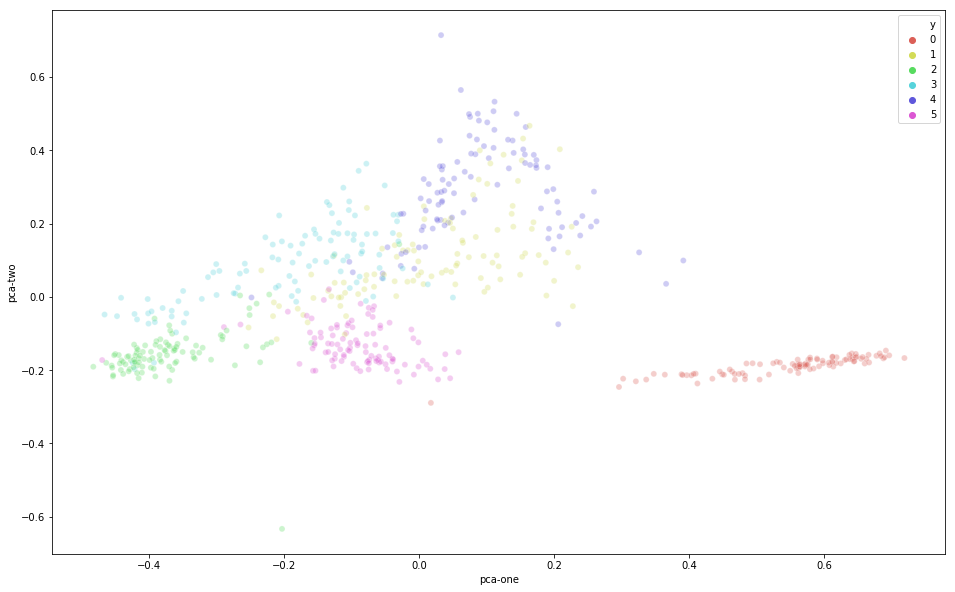

In [216]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(lc_lab))),
    data=df,
    legend="full",
    alpha=0.3
)

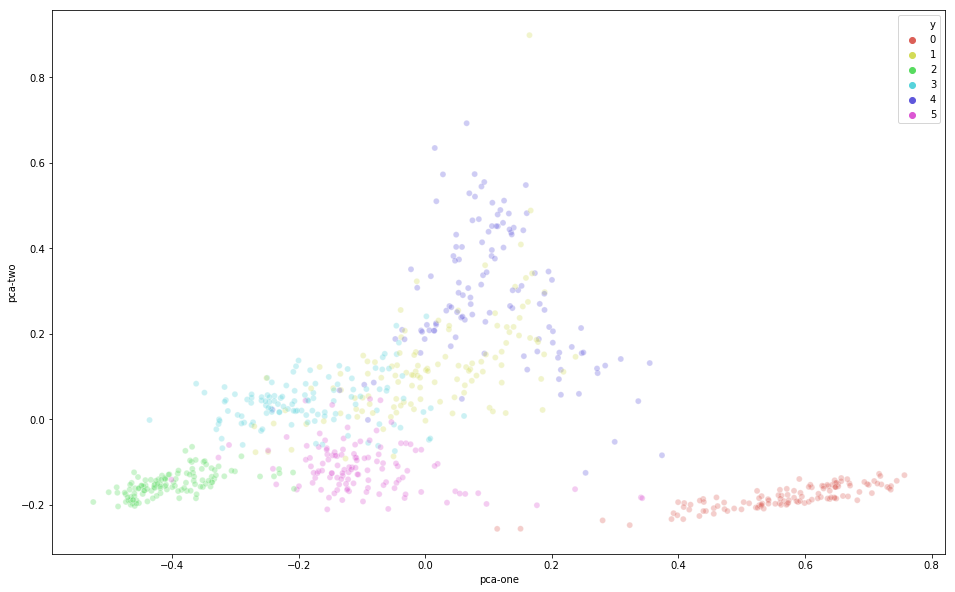

In [90]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(lc_lab))),
    data=df,
    legend="full",
    alpha=0.3
)

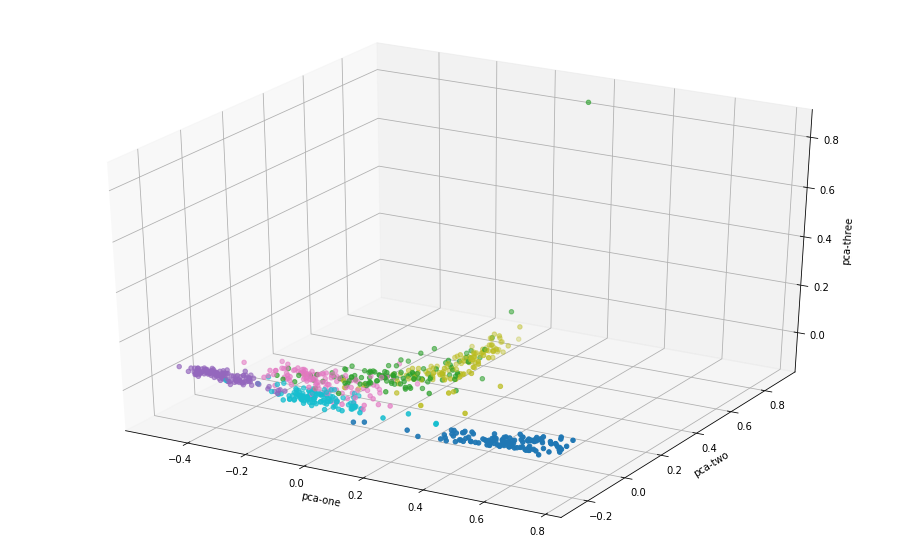

In [91]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [13]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_data[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.001s...
[t-SNE] Computed neighbors for 901 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 1.001957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.736160
[t-SNE] KL divergence after 1000 iterations: 0.467313
t-SNE done! Time elapsed: 5.8433518409729 seconds


In [14]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

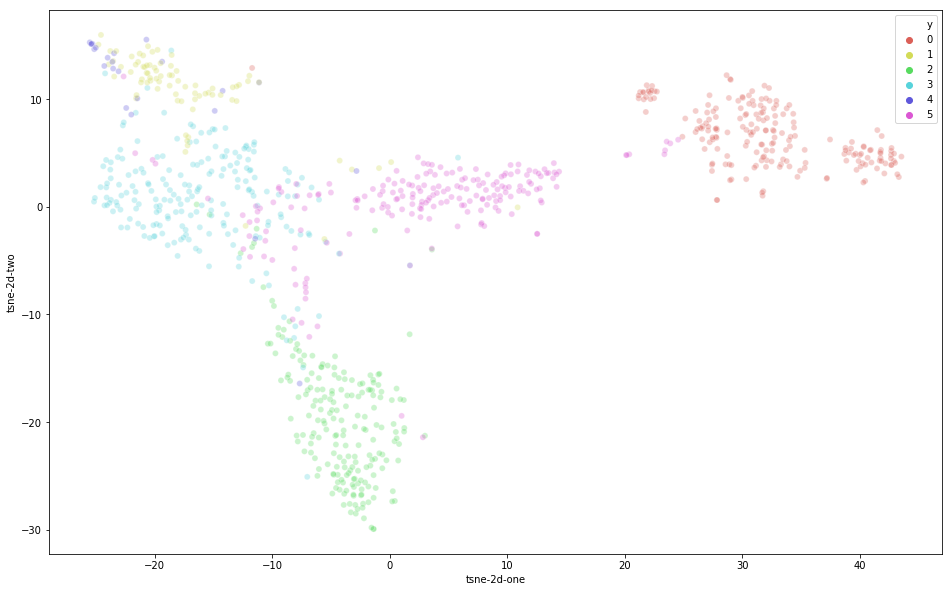

In [15]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df_subset,
    legend="full",
    alpha=0.3
)